# 関数のテスト

In [1]:
import sys
sys.path.append('/Users/LOng/sengokulab/LDAT_LS_2019/scripts/')

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import calc_variogram as variogram
import kriging_est as kriging

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
data = pd.read_csv('/Users/LOng/sengokulab/LDAT_LS_2019/data/dev/house_price_raw.csv')
data['price'] = np.log(data.price)

## Step1: OLSから残差を算出

In [5]:
# 前処理
x = data[['station', 'tokyo']]
y = data['price']

In [6]:
step1 = sm.OLS(y, x)
step1_res = step1.fit()
resid = step1_res.resid

## Step2: 残差からvariogramを推定

In [7]:
# 前処理
resid = pd.DataFrame(resid, columns=['residuals'])
resid = data[['px', 'py']].join(resid)
resid = resid.values

In [8]:
resid

array([[ 1.39362310e+02,  3.57338500e+01, -2.19762641e+00],
       [ 1.39363027e+02,  3.56540780e+01, -2.02881591e+00],
       [ 1.39367082e+02,  3.56598590e+01, -1.56820750e+00],
       [ 1.39369003e+02,  3.56455460e+01, -1.44905066e+00],
       [ 1.39371526e+02,  3.56473230e+01, -1.57131189e+00],
       [ 1.39373562e+02,  3.57275950e+01, -1.24026561e+00],
       [ 1.39374415e+02,  3.56732410e+01, -1.53129022e+00],
       [ 1.39374691e+02,  3.56539720e+01, -1.29646077e+00],
       [ 1.39375802e+02,  3.56629740e+01, -8.90992590e-01],
       [ 1.39377419e+02,  3.56685930e+01, -1.07634726e+00],
       [ 1.39379504e+02,  3.56789730e+01, -1.39733678e+00],
       [ 1.39379862e+02,  3.56816580e+01, -1.50014008e+00],
       [ 1.39380375e+02,  3.56544240e+01, -8.21454976e-01],
       [ 1.39380871e+02,  3.57220070e+01, -1.51691262e+00],
       [ 1.39382431e+02,  3.56486010e+01, -8.36495633e-01],
       [ 1.39382461e+02,  3.56530610e+01, -9.26234389e-01],
       [ 1.39385678e+02,  3.56714310e+01

In [21]:
vario = variogram.get_diff(resid)

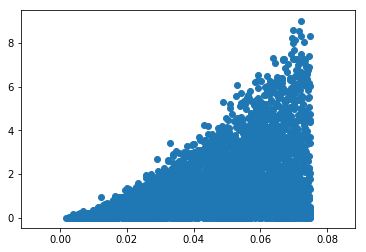

In [175]:
plt.scatter(vario[0], vario[1])

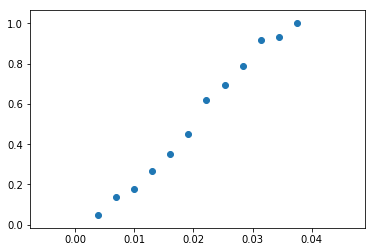

In [23]:
e_vario, lag = variogram.emp_variogram(vario, 12)
plt.scatter(e_vario[0], e_vario[1])

[0.         0.00457977 0.00915954 0.01373932 0.01831909 0.02289886
 0.02747863 0.03205841 0.03663818 0.04121795]
1.4999999999999998 0.03926928078676661


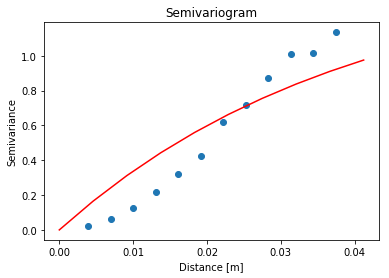

In [178]:
param, lag, fig = variogram.auto_vario(vario, 12, 2)

In [179]:
print(param)

[2.00000000e+00 1.00000000e+02 1.50000000e+00 3.92692808e-02]


## Step3: gls
- 共分散関数を推定
    - 観測値間の距離行列を作成
    - 推定したパラメータから$\hat{C}(0)$を推定
    - 正定値になるように処理を加える(数学的な根拠は不明, Rではどのように処理している?)
- 共分散関数の推定量を用いてgls

In [180]:
distance_mat = kriging.calc_distance_matrix(data, ['px', 'py'])

In [181]:
efrange, c0 = kriging.calc_c0(param, distance_mat)

In [182]:
print(efrange)

0.11780784236029981


In [183]:
print(c0)

0.0746806025517959


In [184]:
# 距離行列と関数形から共分散関数を求める
# reg=Trueなので正定値化処理を加えている
covariance_mat = kriging.est_covariance_matrix(distance_mat, param, c0)

1.3689188252104914


In [185]:
print(covariance_mat)

[[1.44359943 0.19670961 0.2270364  ... 0.03671501 0.03889164 0.04206642]
 [0.19670961 1.44359943 1.25313179 ... 0.10957992 0.10825013 0.10475529]
 [0.2270364  1.25313179 1.44359943 ... 0.1160016  0.11554779 0.11318564]
 ...
 [0.03671501 0.10957992 0.1160016  ... 1.44359943 1.32069146 1.08766612]
 [0.03889164 0.10825013 0.11554779 ... 1.32069146 1.44359943 1.2353286 ]
 [0.04206642 0.10475529 0.11318564 ... 1.08766612 1.2353286  1.44359943]]


In [186]:
# 重みを用いてgls
# statsmodelsのresultクラスが返る
res, resid = kriging.do_gls(y, x, covariance_mat)

In [187]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.955
Model:                            GLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     1327.
Date:                Wed, 24 Apr 2019   Prob (F-statistic):           2.27e-85
Time:                        16:46:58   Log-Likelihood:                 34.761
No. Observations:                 128   AIC:                            -65.52
Df Residuals:                     126   BIC:                            -59.82
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
station      -31.5363      4.673     -6.749      0.000     -40.783     -22.289
tokyo         34.1938      0.664     51.461      0.000      32.879      35.509
==============================================================================
Omnibus:                       65.280   Durbin-Watson:                   1.494
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              272.296
Skew:                           1.813   Prob(JB):                     7.44e-60
Kurtosis:                       9.157   Cond. No.                         7.15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Step4: kirigng
- 観測地点と予測地点の間の共分散関数$c_*$を作成する
    - 距離行列作成
    - 共分散関数にあてはめる
- 足し合わせ $\hat{Y}(s_o) = X(s_0)\hat{\beta}_{gls} + c_*'\hat{\Sigma}^{-1}(Y - X\beta)$

In [188]:
# 前処理
mdat = pd.read_csv('/Users/LOng/sengokulab/LDAT_LS_2019/data/dev/house_price_pred.csv')
mdat.head()

,px,py,price,station,tokyo
0,139.402984,35.767626,NaN,0.017537,0.374249
1,139.407036,35.767626,NaN,0.013571,0.370307
2,139.411089,35.767626,NaN,0.009675,0.366367
3,139.439457,35.767626,NaN,0.001584,0.338865
4,139.394878,35.763700,NaN,0.026327,0.381271


In [189]:
mpoints = mdat[['px', 'py']].values
mexog = mdat[['station', 'tokyo']].values

In [190]:
points = data[['px', 'py']].values

In [191]:
# 距離行列作成
new_dist_mat = kriging.calc_distance_new_data(mpoints, points)

In [192]:
# 距離行列と関数型から共分散行列を推定
# reg=Falseを指定して正定値処理をスキップ(正方行列でないのでエラーを防ぐ)
c_mat = kriging.est_covariance_matrix(new_dist_mat, param, c0, reg=False)

In [193]:
fitted_val = kriging.put_pred_val(res, mexog)

In [194]:
kriging_val = kriging.do_kriging(fitted_val, c_mat, covariance_mat, resid)

## Rでの結果との比較

In [195]:
res_inR = pd.read_csv('/Users/LOng/sengokulab/LDAT_LS_2019/data/dev/krig_res_R.csv')
res_inR = res_inR.iloc[:, 1:-2]

Text(0, 0.5, 'pred by Python')

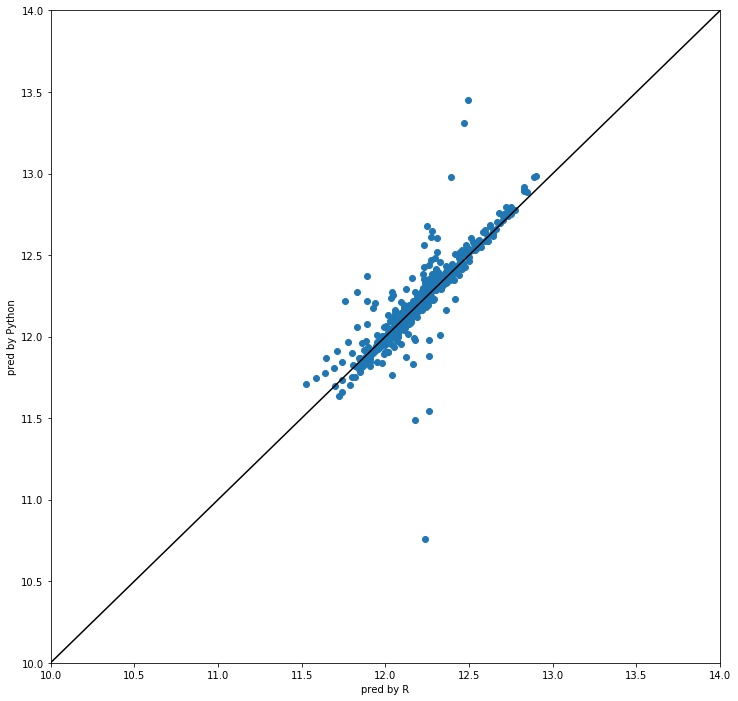

In [196]:
res_fig = plt.figure(figsize=(12, 12))
res_ax = res_fig.add_subplot(1, 1, 1)
res_ax.scatter(res_inR['var1.pred'], kriging_val)
res_ax.plot(np.linspace(10, 14, 1000), np.linspace(10, 14, 1000), color='black')
res_ax.set_xlim(10, 14)
res_ax.set_ylim(10, 14)
res_ax.set_xlabel('pred by R')
res_ax.set_ylabel('pred by Python')
# Rとの結果とそこそこ整合的になった?

In [57]:
res_fig.savefig('/Users/LOng/sengokulab/LDAT_LS_2019/data/dev/plot/kriging_est_func_res2.png')